In [1]:
# imports
import matplotlib.pyplot as plt
import matplotlib
import joblib
import cv2
import os
import torch 
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import random
import pretrainedmodels

from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

matplotlib.style.use('ggplot')

'''SEED Everything'''
def seed_everything(SEED=42):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True # keep True if all the input have same size.
SEED=42
seed_everything(SEED=SEED)
'''SEED Everything'''

'SEED Everything'

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
    print('using cuda')
else:
    device = 'cpu'
 
epochs = 25
BATCH_SIZE = 16

using cuda


In [4]:
fileNames = np.loadtxt('./Train.txt', dtype=np.str, delimiter='\t')
np.random.shuffle(fileNames)

evalNames = np.loadtxt('./Eval.txt', dtype=np.str, delimiter='\t')
np.random.shuffle(evalNames)

# for i in range(len(fileNames)):
    # print(fileNames[i])
    # fileNames[i][0] = dataDir + fileNames[i][0]
print(fileNames)

[['computer-keyboard/045_0013.jpg' '5']
 ['computer-monitor/046_0059.jpg' '6']
 ['computer-monitor/046_0133.jpg' '6']
 ...
 ['doorknob/058_0053.jpg' '8']
 ['video-projector/238_0060.jpg' '14']
 ['head-phones/101_0044.jpg' '11']]


In [5]:
dataDir = './Images/'
testNames = np.loadtxt('./final_Test.txt', dtype=np.str, delimiter='\t')
# np.random.shuffle(testNames)
t_data = []
t_labels = []
for i in range(len(testNames)):
    label = testNames[i][1]
    print(dataDir + testNames[i][0])
    image = cv2.imread(dataDir + testNames[i][0])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
 
    t_data.append(image)
    t_labels.append(int(label))

t_data = np.array(t_data)
t_labels = np.array(t_labels)
# print([int(x) for x in t_labels])
print(t_labels)

./Images/head-phones/101_0073.jpg
./Images/computer-mouse/047_0028.jpg
./Images/binoculars/012_0028.jpg
./Images/palm-pilot/153_0028.jpg
./Images/calculator/027_0055.jpg
./Images/binoculars/012_0100.jpg
./Images/computer-monitor/046_0091.jpg
./Images/joy-stick/120_0073.jpg
./Images/washing-machine/239_0010.jpg
./Images/binoculars/012_0145.jpg
./Images/computer-monitor/046_0046.jpg
./Images/flashlight/074_0091.jpg
./Images/binoculars/012_0019.jpg
./Images/cannon/029_0028.jpg
./Images/computer-mouse/047_0019.jpg
./Images/computer-keyboard/045_0046.jpg
./Images/joy-stick/120_0109.jpg
./Images/computer-monitor/046_0010.jpg
./Images/computer-mouse/047_0091.jpg
./Images/computer-keyboard/045_0019.jpg
./Images/boom-box/016_0064.jpg
./Images/binoculars/012_0208.jpg
./Images/head-phones/101_0055.jpg
./Images/dumb-bell/061_0019.jpg
./Images/head-phones/101_0127.jpg
./Images/dumb-bell/061_0073.jpg
./Images/boom-box/016_0019.jpg
./Images/palm-pilot/153_0001.jpg
./Images/flashlight/074_0019.jpg
./I

In [7]:
# image_paths = list(paths.list_images('../input/101_ObjectCategories'))

e_data = []
e_labels = []
data = []
labels = []
for i in range(len(fileNames)):
    label = fileNames[i][1]
    image = cv2.imread(dataDir + fileNames[i][0])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
 
    data.append(image)
    labels.append(int(label))

data = np.array(data)
labels = np.array(labels)

for i in range(len(evalNames)):
    label = evalNames[i][1]
    image = cv2.imread(dataDir + evalNames[i][0])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
 
    e_data.append(image)
    e_labels.append(int(label))

e_data = np.array(e_data)
e_labels = np.array(e_labels)

In [8]:
print(labels)

[ 4 14 10 ...  2  8 12]


In [10]:
# one hot encode
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
e_labels = lb.fit_transform(e_labels)
t_labels = lb.fit_transform(t_labels)
# print(labels)
print(t_labels[0])
print(f"Total number of classes: {len(lb.classes_)}")

[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
Total number of classes: 16


In [ ]:
print(lb.inverse_transform(t_labels))

In [11]:
# define transforms
train_transform = transforms.Compose(
    [transforms.ToPILImage(),
	 transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])
val_transform = transforms.Compose(
    [transforms.ToPILImage(),
	 transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])

In [ ]:
# 可改变，尝试使用给出的Eval.txt和Test.txt
# divide the data into train, validation, and test set
(X, x_val , Y, y_val) = train_test_split(data, labels, 
                                                    test_size=0.2,  
                                                    stratify=labels,
                                                    random_state=42)

(x_train, x_test, y_train, y_test) = train_test_split(X, Y, 
                                                    test_size=0.25, 
                                                    random_state=42)

print(f"x_train examples: {x_train.shape}\nx_test examples: {x_test.shape}\nx_val examples: {x_val.shape}")
print(type(x_train))
print(y_val)

In [12]:
# print(x_train)
(x_train, y_train) = (data, labels)
(x_val, y_val) = (e_data, e_labels)
(x_ftest, y_ftest) = (t_data, t_labels)
print(f"x_train examples: {x_train.shape}\nx_val examples: {x_val.shape}")
print(f"final_test examples: {x_ftest.shape}")
# print(type(x_ftest))
print(t_labels)
print(y_ftest)

x_train examples: (1567,)
x_val examples: (205,)
final_test examples: (205,)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [13]:
# custom dataset
class ImageDataset(Dataset):
    def __init__(self, images, labels=None, transforms=None):
        self.X = images
        self.y = labels
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        data = self.X[i][:]
        
        if self.transforms:
            data = self.transforms(data)
            
        if self.y is not None:
            return (data, self.y[i])
        else:
            return data
        
train_data = ImageDataset(x_train, y_train, train_transform)
val_data = ImageDataset(x_val, y_val, val_transform)
# test_data = ImageDataset(x_test, y_test, val_transform)
# print(x_test)
# print(val_transform)
final_test_data = ImageDataset(x_ftest, y_ftest, val_transform)

In [14]:
# dataloaders
trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False)
valloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
testloader = DataLoader(final_test_data, batch_size=BATCH_SIZE, shuffle=False)

In [15]:
# the resnet34 model
class ResNet34(nn.Module):
    def __init__(self, pretrained):
        super(ResNet34, self).__init__()
        if pretrained is True:
            self.model = pretrainedmodels.__dict__['resnet34'](pretrained='imagenet')
        else:
            self.model = pretrainedmodels.__dict__['resnet34'](pretrained=None)
        
        # change the classification layer
        self.l0 = nn.Linear(512, len(lb.classes_))
        self.dropout = nn.Dropout2d(0.4)

    def forward(self, x):
        # get the batch size only, ignore (c, h, w)
        batch, _, _, _ = x.shape
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        x = self.dropout(x)
        l0 = self.l0(x)
        return l0

model = ResNet34(pretrained=True).to(device)

In [16]:
# optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)
# loss function
criterion = nn.CrossEntropyLoss()

In [17]:
# training function
def fit(model, dataloader):
    print('Training')
    model.train()
    running_loss = 0.0
    running_correct = 0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, torch.max(target, 1)[1])
        running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        running_correct += (preds == torch.max(target, 1)[1]).sum().item()
        loss.backward()
        optimizer.step()
        
    loss = running_loss/len(dataloader.dataset)
    accuracy = 100. * running_correct/len(dataloader.dataset)
    
    print(f"Train Loss: {loss:.4f}, Train Acc: {accuracy:.2f}")
    
    return loss, accuracy

In [18]:
#validation function
def validate(model, dataloader):
    print('Validating')
    model.eval()
    running_loss = 0.0
    running_correct = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            data, target = data[0].to(device), data[1].to(device)
            outputs = model(data)
            loss = criterion(outputs, torch.max(target, 1)[1])
            
            running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            running_correct += (preds == torch.max(target, 1)[1]).sum().item()
        
        loss = running_loss/len(dataloader.dataset)
        accuracy = 100. * running_correct/len(dataloader.dataset)
        print(f'Val Loss: {loss:.4f}, Val Acc: {accuracy:.2f}')
        
        return loss, accuracy

In [19]:
def test(model, dataloader):
    correct = 0
    total = 0
    with open('result_raw.txt', 'w') as out_file:
        with torch.no_grad():
            for data in testloader:
                inputs, target = data[0].to(device), data[1].to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                print(predicted)
                # print(torch.max(target, 1)[1])
                out_file.write(str(predicted))
                out_file.write('\n')
                total += target.size(0)
                correct += (predicted == torch.max(target, 1)[1]).sum().item()
 
    return correct, total

  0%|                                                                                           | 0/97 [00:00<?, ?it/s]

Training on 1567 examples, validating on 205 examples...
Epoch 1 of 25
Training


98it [00:11,  8.65it/s]                                                                                                
 17%|█████████████▊                                                                     | 2/12 [00:00<00:00, 16.44it/s]

Train Loss: 0.0700, Train Acc: 69.75
Validating


13it [00:00, 14.04it/s]                                                                                                
  2%|█▋                                                                                 | 2/97 [00:00<00:08, 11.71it/s]

Val Loss: 0.0208, Val Acc: 90.73
Epoch 2 of 25
Training


98it [00:08, 10.96it/s]                                                                                                
 17%|█████████████▊                                                                     | 2/12 [00:00<00:00, 16.71it/s]

Train Loss: 0.0110, Train Acc: 96.94
Validating


13it [00:00, 17.04it/s]                                                                                                
  2%|█▋                                                                                 | 2/97 [00:00<00:07, 12.00it/s]

Val Loss: 0.0148, Val Acc: 94.15
Epoch 3 of 25
Training


98it [00:08, 10.91it/s]                                                                                                
 17%|█████████████▊                                                                     | 2/12 [00:00<00:00, 15.43it/s]

Train Loss: 0.0029, Train Acc: 99.62
Validating


13it [00:00, 15.90it/s]                                                                                                
  2%|█▋                                                                                 | 2/97 [00:00<00:08, 11.73it/s]

Val Loss: 0.0128, Val Acc: 92.68
Epoch 4 of 25
Training


98it [00:08, 10.94it/s]                                                                                                
 17%|█████████████▊                                                                     | 2/12 [00:00<00:00, 15.79it/s]

Train Loss: 0.0012, Train Acc: 100.00
Validating


13it [00:00, 16.52it/s]                                                                                                
  2%|█▋                                                                                 | 2/97 [00:00<00:07, 11.94it/s]

Val Loss: 0.0114, Val Acc: 94.15
Epoch 5 of 25
Training


98it [00:08, 10.90it/s]                                                                                                
 17%|█████████████▊                                                                     | 2/12 [00:00<00:00, 16.71it/s]

Train Loss: 0.0006, Train Acc: 100.00
Validating


13it [00:00, 16.62it/s]                                                                                                
  2%|█▋                                                                                 | 2/97 [00:00<00:07, 12.08it/s]

Val Loss: 0.0110, Val Acc: 94.15
Epoch 6 of 25
Training


98it [00:09, 10.89it/s]                                                                                                
 17%|█████████████▊                                                                     | 2/12 [00:00<00:00, 15.79it/s]

Train Loss: 0.0004, Train Acc: 100.00
Validating


13it [00:00, 16.13it/s]                                                                                                
  2%|█▋                                                                                 | 2/97 [00:00<00:07, 12.38it/s]

Val Loss: 0.0104, Val Acc: 94.63
Epoch 7 of 25
Training


98it [00:09, 10.88it/s]                                                                                                
 17%|█████████████▊                                                                     | 2/12 [00:00<00:00, 16.30it/s]

Train Loss: 0.0003, Train Acc: 100.00
Validating


13it [00:00, 16.51it/s]                                                                                                
  2%|█▋                                                                                 | 2/97 [00:00<00:07, 12.08it/s]

Val Loss: 0.0103, Val Acc: 95.12
Epoch 8 of 25
Training


98it [00:09, 10.48it/s]                                                                                                
 17%|█████████████▊                                                                     | 2/12 [00:00<00:00, 16.11it/s]

Train Loss: 0.0003, Train Acc: 100.00
Validating


13it [00:00, 16.73it/s]                                                                                                
  2%|█▋                                                                                 | 2/97 [00:00<00:07, 12.08it/s]

Val Loss: 0.0102, Val Acc: 95.12
Epoch 9 of 25
Training


98it [00:09, 10.66it/s]                                                                                                
 17%|█████████████▊                                                                     | 2/12 [00:00<00:00, 15.30it/s]

Train Loss: 0.0002, Train Acc: 100.00
Validating


13it [00:00, 15.24it/s]                                                                                                
  2%|█▋                                                                                 | 2/97 [00:00<00:07, 12.08it/s]

Val Loss: 0.0102, Val Acc: 94.63
Epoch 10 of 25
Training


98it [00:09, 10.33it/s]                                                                                                
 17%|█████████████▊                                                                     | 2/12 [00:00<00:00, 13.64it/s]

Train Loss: 0.0002, Train Acc: 100.00
Validating


13it [00:00, 15.28it/s]                                                                                                
  2%|█▋                                                                                 | 2/97 [00:00<00:07, 12.46it/s]

Val Loss: 0.0100, Val Acc: 95.12
Epoch 11 of 25
Training


98it [00:08, 11.00it/s]                                                                                                
 17%|█████████████▊                                                                     | 2/12 [00:00<00:00, 16.71it/s]

Train Loss: 0.0002, Train Acc: 100.00
Validating


13it [00:00, 17.52it/s]                                                                                                
  2%|█▋                                                                                 | 2/97 [00:00<00:07, 12.08it/s]

Val Loss: 0.0101, Val Acc: 95.12
Epoch 12 of 25
Training


98it [00:08, 11.00it/s]                                                                                                
 17%|█████████████▊                                                                     | 2/12 [00:00<00:00, 14.97it/s]

Train Loss: 0.0001, Train Acc: 100.00
Validating


13it [00:00, 15.76it/s]                                                                                                
  2%|█▋                                                                                 | 2/97 [00:00<00:07, 12.23it/s]

Val Loss: 0.0100, Val Acc: 95.12
Epoch 13 of 25
Training


98it [00:08, 10.93it/s]                                                                                                
 17%|█████████████▊                                                                     | 2/12 [00:00<00:00, 16.17it/s]

Train Loss: 0.0001, Train Acc: 100.00
Validating


13it [00:00, 16.76it/s]                                                                                                
  2%|█▋                                                                                 | 2/97 [00:00<00:07, 12.49it/s]

Val Loss: 0.0098, Val Acc: 95.12
Epoch 14 of 25
Training


98it [00:08, 10.97it/s]                                                                                                
 17%|█████████████▊                                                                     | 2/12 [00:00<00:00, 15.27it/s]

Train Loss: 0.0001, Train Acc: 100.00
Validating


13it [00:00, 16.35it/s]                                                                                                
  2%|█▋                                                                                 | 2/97 [00:00<00:08, 11.33it/s]

Val Loss: 0.0098, Val Acc: 95.12
Epoch 15 of 25
Training


98it [00:09, 10.84it/s]                                                                                                
 17%|█████████████▊                                                                     | 2/12 [00:00<00:00, 14.64it/s]

Train Loss: 0.0001, Train Acc: 100.00
Validating


13it [00:00, 16.33it/s]                                                                                                
  2%|█▋                                                                                 | 2/97 [00:00<00:08, 11.80it/s]

Val Loss: 0.0099, Val Acc: 95.12
Epoch 16 of 25
Training


98it [00:08, 10.94it/s]                                                                                                
 17%|█████████████▊                                                                     | 2/12 [00:00<00:00, 12.77it/s]

Train Loss: 0.0001, Train Acc: 100.00
Validating


13it [00:00, 14.73it/s]                                                                                                
  2%|█▋                                                                                 | 2/97 [00:00<00:07, 12.08it/s]

Val Loss: 0.0098, Val Acc: 95.12
Epoch 17 of 25
Training


98it [00:08, 10.96it/s]                                                                                                
 17%|█████████████▊                                                                     | 2/12 [00:00<00:00, 15.01it/s]

Train Loss: 0.0001, Train Acc: 100.00
Validating


13it [00:00, 15.76it/s]                                                                                                
  2%|█▋                                                                                 | 2/97 [00:00<00:08, 11.55it/s]

Val Loss: 0.0095, Val Acc: 95.12
Epoch 18 of 25
Training


98it [00:08, 10.92it/s]                                                                                                
 17%|█████████████▊                                                                     | 2/12 [00:00<00:00, 16.37it/s]

Train Loss: 0.0001, Train Acc: 100.00
Validating


13it [00:00, 16.64it/s]                                                                                                
  2%|█▋                                                                                 | 2/97 [00:00<00:07, 12.17it/s]

Val Loss: 0.0097, Val Acc: 95.12
Epoch 19 of 25
Training


98it [00:09, 10.29it/s]                                                                                                
 17%|█████████████▊                                                                     | 2/12 [00:00<00:00, 14.32it/s]

Train Loss: 0.0001, Train Acc: 100.00
Validating


13it [00:00, 15.26it/s]                                                                                                
  2%|█▋                                                                                 | 2/97 [00:00<00:07, 12.01it/s]

Val Loss: 0.0096, Val Acc: 95.12
Epoch 20 of 25
Training


98it [00:10,  9.56it/s]                                                                                                
 17%|█████████████▊                                                                     | 2/12 [00:00<00:00, 14.43it/s]

Train Loss: 0.0001, Train Acc: 100.00
Validating


13it [00:00, 14.82it/s]                                                                                                
  2%|█▋                                                                                 | 2/97 [00:00<00:08, 11.02it/s]

Val Loss: 0.0096, Val Acc: 94.63
Epoch 21 of 25
Training


98it [00:10,  9.74it/s]                                                                                                
 17%|█████████████▊                                                                     | 2/12 [00:00<00:00, 15.67it/s]

Train Loss: 0.0001, Train Acc: 100.00
Validating


13it [00:00, 16.18it/s]                                                                                                
  2%|█▋                                                                                 | 2/97 [00:00<00:08, 11.33it/s]

Val Loss: 0.0097, Val Acc: 94.63
Epoch 22 of 25
Training


98it [00:09, 10.08it/s]                                                                                                
 17%|█████████████▊                                                                     | 2/12 [00:00<00:00, 16.30it/s]

Train Loss: 0.0001, Train Acc: 100.00
Validating


13it [00:00, 16.81it/s]                                                                                                
  2%|█▋                                                                                 | 2/97 [00:00<00:07, 11.98it/s]

Val Loss: 0.0097, Val Acc: 94.63
Epoch 23 of 25
Training


98it [00:09, 10.83it/s]                                                                                                
 17%|█████████████▊                                                                     | 2/12 [00:00<00:00, 15.08it/s]

Train Loss: 0.0000, Train Acc: 100.00
Validating


13it [00:00, 16.35it/s]                                                                                                
  2%|█▋                                                                                 | 2/97 [00:00<00:08, 11.65it/s]

Val Loss: 0.0097, Val Acc: 94.63
Epoch 24 of 25
Training


98it [00:09, 10.75it/s]                                                                                                
 17%|█████████████▊                                                                     | 2/12 [00:00<00:00, 14.91it/s]

Train Loss: 0.0000, Train Acc: 100.00
Validating


13it [00:00, 15.73it/s]                                                                                                
  2%|█▋                                                                                 | 2/97 [00:00<00:07, 12.15it/s]

Val Loss: 0.0095, Val Acc: 94.63
Epoch 25 of 25
Training


98it [00:09, 10.54it/s]                                                                                                
 17%|█████████████▊                                                                     | 2/12 [00:00<00:00, 14.43it/s]

Train Loss: 0.0000, Train Acc: 100.00
Validating


13it [00:00, 14.85it/s]                                                                                                


Val Loss: 0.0095, Val Acc: 95.12
4.2080457011858625 minutes


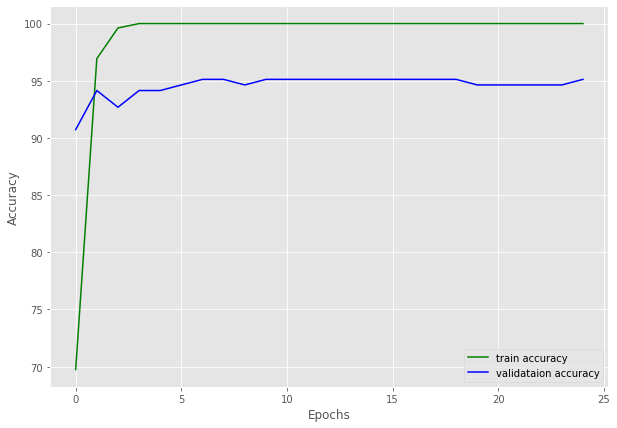

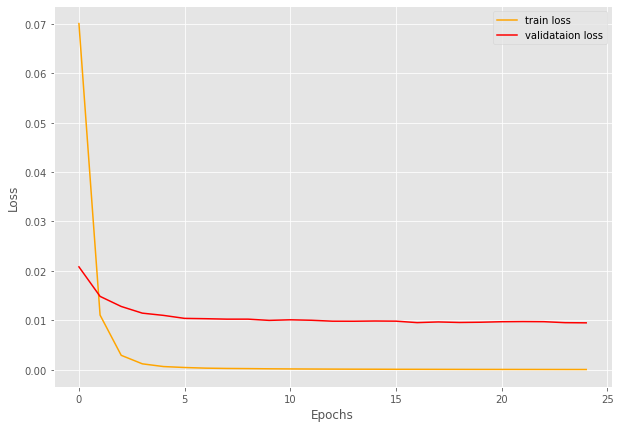

In [20]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
print(f"Training on {len(train_data)} examples, validating on {len(val_data)} examples...")
start = time.time()
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_accuracy = fit(model, trainloader)
    val_epoch_loss, val_epoch_accuracy = validate(model, valloader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
end = time.time()
print((end-start)/60, 'minutes')
 
torch.save(model.state_dict(), f"resnet34_epochs{epochs}.pth")
 
# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy.png')
 
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss.png')

In [21]:
# save the accuracy and loss lists as pickled files
print('Pickling accuracy and loss lists...')
joblib.dump(train_accuracy, 'train_accuracy.pkl')
joblib.dump(train_loss, 'train_loss.pkl')
joblib.dump(val_accuracy, 'val_accuracy.pkl')
joblib.dump(val_loss, 'val_loss.pkl')

Pickling accuracy and loss lists...


['val_loss.pkl']

In [24]:
correct, total = test(model, testloader)
print(correct, total)
print('Accuracy of the network on test images: %0.3f %%' % (100 * correct / total))
print('train.py finished running')

tensor([11,  7,  1, 13,  3,  1,  6, 12, 15,  1,  6, 10,  1,  4,  7,  5],
       device='cuda:0')
tensor([12,  6,  7,  5,  2,  4, 11,  9, 11,  9,  2, 13, 10,  7,  3,  1],
       device='cuda:0')
tensor([15,  3,  4,  5,  1,  6,  8,  8, 12,  2,  4,  5, 10,  7,  7, 14],
       device='cuda:0')
tensor([11, 12, 14,  1, 15,  2, 10,  3, 11, 14,  5,  8,  1,  3, 14,  9],
       device='cuda:0')
tensor([ 9, 15,  3, 14, 14, 13, 12,  3, 12,  4,  6, 10,  6, 11,  0,  2],
       device='cuda:0')
tensor([15,  4, 13, 12,  6, 10,  2, 11,  6, 10,  3,  1,  9, 12,  1,  6],
       device='cuda:0')
tensor([ 8,  2, 12, 10, 15, 10,  5,  2,  1,  1,  9,  9,  7,  5, 11,  6],
       device='cuda:0')
tensor([ 0, 13, 11,  4,  6,  6, 12,  7,  1, 15,  1,  9,  4,  3,  8, 11],
       device='cuda:0')
tensor([ 5,  0, 12, 12,  1,  9, 11,  0, 12,  5, 15, 12,  6,  9,  1,  8],
       device='cuda:0')
tensor([ 0,  5,  1,  1,  3, 11,  7,  4, 10, 13, 14,  7,  6, 13,  3,  9],
       device='cuda:0')
tensor([14, 10,  4,  0, 15,  1

In [4]:
import re

pat1 = r'%s(.+?)%s' % ('\[', '\]')
p = re.compile(pat1, re.IGNORECASE)

with open('result_raw.txt', 'r') as in_file:
    with open('result.txt', 'w', encoding='utf-8', newline='\n') as out_file:
        lines = in_file.readlines()
        for line in lines:
            row = re.findall(p, line)
            if row:
                num_list = [str(x.strip()) for x in row[0].split(',')]
                for i in num_list:
                    out_file.write(i)
                    out_file.write('\n')
                    
print('parsing done.')

parsing done.


In [3]:
train_acc = joblib.load('train_accuracy.pkl')

In [4]:
print(train_acc)

[69.75111678366305, 96.936821952776, 99.617102744097, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
